In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

/opt/conda/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


<h2>Part 1: Regression analysis of Gapminder data<h2>

In [2]:
df = pd.read_csv('mirror/08_gap-every-five-years.tsv', sep='\t')

In [3]:
df.head()

,country,continent,year,lifeExp,pop,gdpPercap
0,Afghanistan,Asia,1952,28.801,8425333,779.445314
1,Afghanistan,Asia,1957,30.332,9240934,820.853030
2,Afghanistan,Asia,1962,31.997,10267083,853.100710
3,Afghanistan,Asia,1967,34.020,11537966,836.197138
4,Afghanistan,Asia,1972,36.088,13079460,739.981106


#### Exercise 1

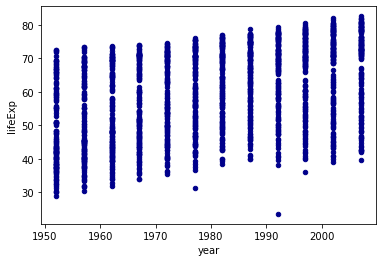

In [4]:
ax1 = df.plot.scatter(x='year', y='lifeExp', c='DarkBlue')

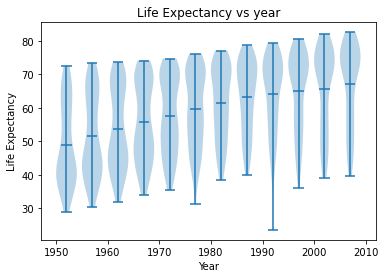

In [5]:
fig, ax = plt.subplots()

life_exp_per_year = df.groupby("year")["lifeExp"].apply(list)                                   

ax.violinplot(life_exp_per_year, df.year.unique(), widths=4,showmeans=True)
ax.set_xlabel("Year")
ax.set_ylabel("Life Expectancy")
ax.set_title("Life Expectancy vs year")
fig.savefig("violin.png")

#### Question 1

The general trend is a steady increase, and it appears to be linear.

#### Question 2

The distribution of life expectancy across the years seem to be bimodal. Earlier in time, the distribution appears to be more left skewed, but slow skews more and more towards the right.

#### Question 3

I would reject the null hypothesis of no relationship because there seems to be a steady increase of life expectancy overtime.

#### Question 4

Since the plot is skewed left earlier on and skewed right later, I expect there to be more residual point above the regression line and more points to be below it later. Therefore, the violin plot would be reversed in that it would skew right earlier and skewed left earlier, but they should still be bimodal and the center should stay around 0.

#### Question 5

In a linear regression mode, all residuals should average to close to 0, unless there are outliers and we are using squared loss, which might affect some years. A successful linear regression should also mean the residuals are distributed normally around the prediction.

#### Excercise 2

In [6]:
lm = linear_model.LinearRegression()
length = len(df.index)
lm.fit(df.year.values.reshape(length, 1), df.lifeExp.values.reshape(length,1))

LinearRegression()

#### Question 6

In [7]:
lm.coef_

array([[0.32590383]])

In [8]:
lm.intercept_

array([-585.65218744])

On average, the life expectancy increase by 0.326 years per year.

#### Question 7

In [9]:
lm.score(df.year.values.reshape(length, 1), df.lifeExp.values.reshape(length,1))

0.18975713852188814

I cannot the null hypothesis of no relationship between year and life expectancy because the r squared value is too low, meaning the relationship is not strong enough to demosntratate signficance.

#### Exercise 3

In [10]:
lm.predict(df.year.values.reshape(length, 1)).flatten()

array([50.51208411, 52.14160324, 53.77112238, ..., 65.17775635,
       66.80727549, 68.43679463])

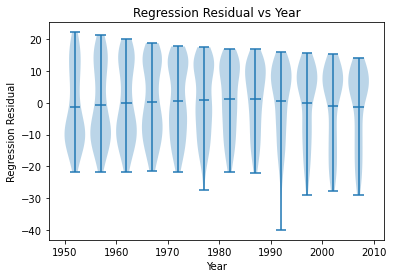

In [11]:
fig, ax = plt.subplots()

df["residual"] = df["lifeExp"] - lm.predict(df.year.values.reshape(length, 1)).flatten()
residuals = df.groupby("year")["residual"].apply(list)

ax.violinplot(residuals, df.year.unique(), widths=4,showmeans=True)
ax.set_xlabel("Year")
ax.set_ylabel("Regression Residual")
ax.set_title("Regression Residual vs Year")
fig.savefig("residual violin.png")

#### Question 8

The plot did not match my expectation, and I realize I've made a mistake. If there are more data points above the regression line, then it should still skew right. Therefore, each year have the same skew with the previous violin plot. I was correct in that the center remained close to 0 across the years with the years with outlier seeming a bit affected.

#### Exercise 4

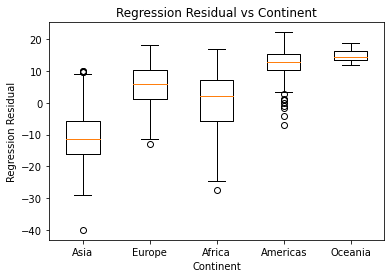

In [12]:
fig, ax = plt.subplots()

residuals = df.groupby("continent")["residual"].apply(list)

ax.boxplot(residuals, labels= df.continent.unique())
ax.set_xlabel("Continent")
ax.set_ylabel("Regression Residual")
ax.set_title("Regression Residual vs Continent")
fig.savefig("continent residual violin.png")

#### Question 9

There is in fact a dependence between model residual and continent, with specifically Asian countries having considerably lower model residuals. This means when directly conducting linear regression of life expectancy against time, it underfits because the model cannot account for the trend of diffrent continents.

#### Exercise 5

Africa coefficient: [[0.28952926]]
Americas coefficient: [[0.36765094]]
Asia coefficient: [[0.4531224]]
Europe coefficient: [[0.22193214]]
Oceania coefficient: [[0.21027238]]


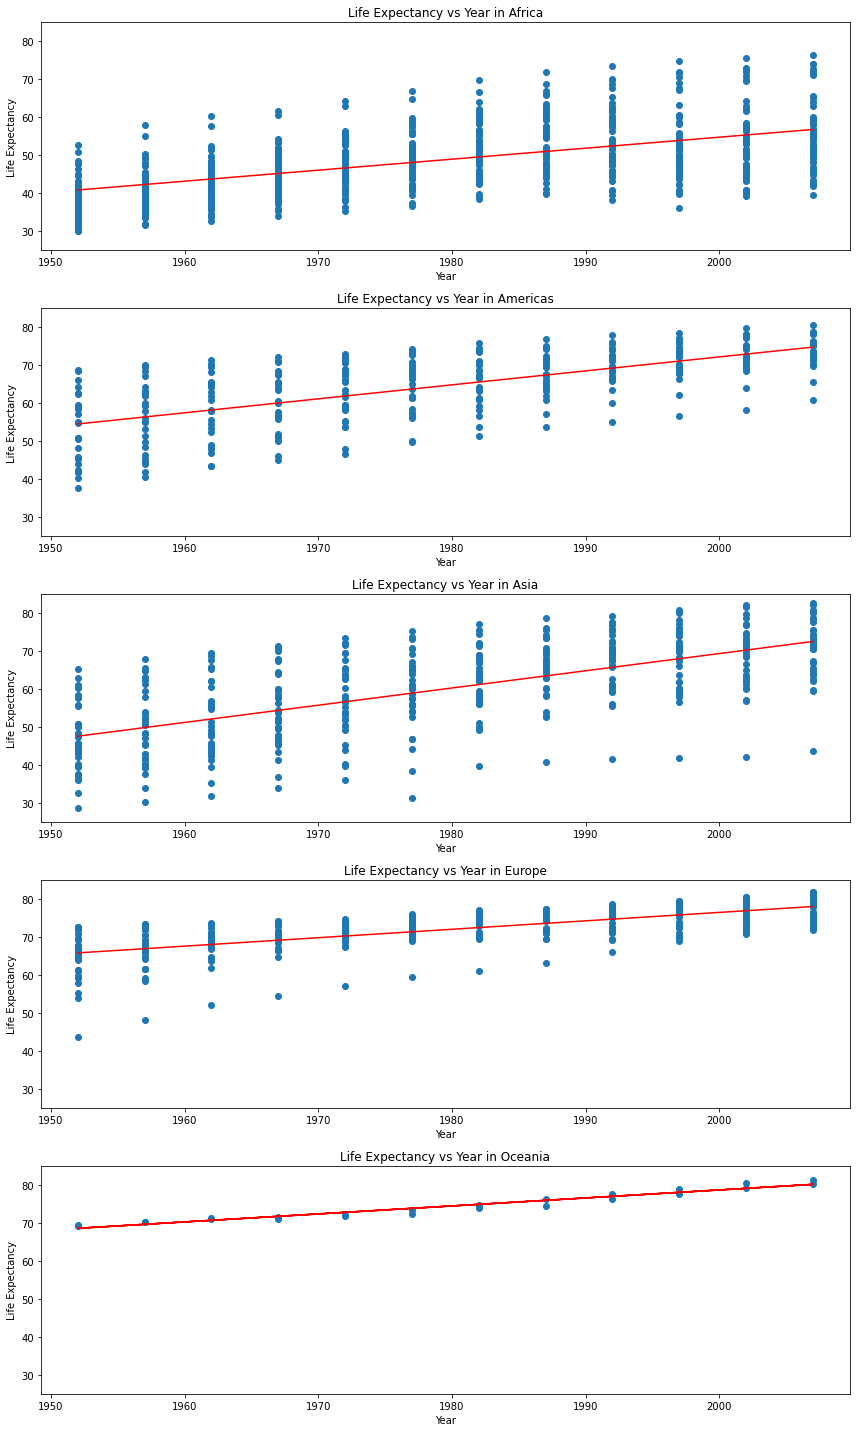

In [13]:
fig, axs = plt.subplots(5, figsize = (12,20))
i = 0
for name, group in df.groupby("continent"):
    length = len(group.index)
    lm.fit(group.year.values.reshape(length, 1), group.lifeExp.values.reshape(length,1))
    years = group.year.values.reshape(length, 1)
    axs[i].plot(years, lm.predict(years), color='red')
    axs[i].scatter(group["year"], group["lifeExp"])
    axs[i].set_xlabel("Year")
    axs[i].set_ylabel("Life Expectancy")
    axs[i].set_title("Life Expectancy vs Year in " +  name)
    axs[i].set_ylim(25, 85)
    print(name + " coefficient: " + str(lm.coef_))
    i = i+1
plt.tight_layout()

#### Question 10

 Based on this plot, my regression model include an interaction term for continent and year because with y scale set constant, it is clear that the regression model for each continent have different coefficients.

#### Excercise 6

In [14]:
length = len(df.index)
one_hot = pd.get_dummies(df.continent)
one_hot["Europe"] = one_hot["Europe"] + one_hot["Oceania"] 
one_hot = one_hot.drop(columns = ["Africa", "Oceania"])
## Combining Europe and Oceania because the have extremely similar trends.
idf = np.concatenate((df.year.values.reshape(length, 1), one_hot.values), axis = 1)

In [15]:
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
lm.fit(poly.fit_transform(idf), df.lifeExp.values.reshape(length, 1),)

LinearRegression()

In [16]:
lm.coef_

array([[ 2.89529263e-01, -1.38848447e+02, -3.12633049e+02,
         1.58440792e+02,  7.81216740e-02,  1.63593141e-01,
        -6.83258540e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])

In [17]:
lm.intercept_

array([-524.25784607])

#### Question 11

In [18]:
results = sm.OLS(df.lifeExp.values.reshape(length, 1),sm.add_constant(poly.fit_transform(idf))).fit()
results.summary()

/opt/conda/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1917: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     544.9
Date:                Wed, 27 Apr 2022   Prob (F-statistic):               0.00
Time:                        22:37:15   Log-Likelihood:                -5773.2
No. Observations:                1704   AIC:                         1.156e+04
Df Residuals:                    1696   BIC:                         1.161e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -524.2578     32.969    -15.902      0.000    -588.922    -459.594
x1             0.2895      0.017     17.384      0.000       0.257       0.322
x2          -138.8484     57.860     -2.400      0.017    -252.334     -25.363
x3          -312.6330     52.913     -5.908      0.000    -416.414    -208.852
x4           158.4408     53.416      2.966      0.003      53.673     263.209
x5             0.0781      0.029      2.673      0.008       0.021       0.135
x6             0.1636      0.027      6.120      0.000       0.111       0.216
x7            -0.0683      0.027     -2.532      0.011      -0.121      -0.015
x8                  0          0        nan        nan           0           0
x9                  0          0        nan        nan           0           0
x10                 0          0        nan        nan           0           0
==============================================================================
Omnibus:                       27.074   Durbin-Watson:                   0.242
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.707
Skew:                          -0.124   Prob(JB):                     3.23e-10
Kurtosis:                       3.744   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

x8, x9, and x10 are actually 0, so they must not be statistically significant at all. As for the other coefficients, statsmodel summary points to them all being significantly different from 0, with the largest p value being 0.017 which is sufficiently small by most common standards.

#### Question 12

On average, life expectancy in Africa increases about 0.2895 years per year, life expectancy in Americas increase 0.2895+0.0781 = 0.3676 years per year, life expectancy in Asia increase 0.2895+0.1636=0.4531 years per year, and life expectancy in Europe and Oceania increase 0.2895-0.0683=0.2212 years per year.

fig, ax = plt.subplots()

df["residual"] = df["lifeExp"] - lm.predict(df.year.values.reshape(length, 1)).flatten()
residuals = df.groupby("year")["residual"].apply(list)

ax.violinplot(residuals, df.year.unique(), widths=4,showmeans=True)
ax.set_xlabel("Year")
ax.set_ylabel("Regression Residual")
ax.set_title("Regression Residual vs Year")
fig.savefig("residual violin.png")#### Exercise 7

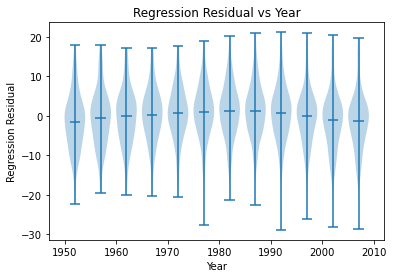

In [19]:
fig, ax = plt.subplots()

df["residual"] = df["lifeExp"] - lm.predict(poly.fit_transform(idf)).flatten()
residuals = df.groupby("year")["residual"].apply(list)

ax.violinplot(residuals, df.year.unique(), widths=4,showmeans=True)
ax.set_xlabel("Year")
ax.set_ylabel("Regression Residual")
ax.set_title("Regression Residual vs Year")
fig.savefig("residual violin.png")

This matches the assumption of linear regression model, and there is no long any skewed pattern of residuals around each year.

<h2>Part 2: Classification<h2>

In [20]:
from sklearn.datasets import load_wine
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold 
wine=load_wine()

For this dataset, we are classifying wine to three classes (class_0, class_1, class_2). To do so, we use 13 predictive numeric attributes (Alcohol, Malic acid, Ash, Alcalinity of ash, Magnesium, Total phenols, Flavanoids, Nonflavanoid phenols, Proanthocyanins, Color intensity, Hue, OD280/OD315 of diluted wines, Proline). 

I'm choosing not to load data into dataframe because it is completely unnecessary for the purpose of this project.

In [21]:
import math
math.sqrt(len(wine.target))

13.341664064126334

k should be around 13 using the principle of estimating k around sqrt(n), and by testing around values slightly above and beyond (11~15) I found k=14 to be the ideal hyperparameter,

In [22]:
k=14
knn = KNeighborsClassifier(n_neighbors=k)

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
forest = RandomForestClassifier(n_estimators=100)
forest.fit(wine.data, wine.target)

RandomForestClassifier()

Tested the number trees being set to 10, 100, 300, 500. Can no longer see significant gain at 100.

In [25]:
knn_acc_sum = 0
forest_acc_sum = 0
kf = KFold(n_splits=10)
for train_index , test_index in kf.split(wine.data):
    x_train , x_test = wine.data[train_index,:], wine.data[test_index,:]
    y_train , y_test = wine.target[train_index] , wine.target[test_index]
     
    knn.fit(x_train,y_train)
    predictions = knn.predict(x_test)

    knn_acc_sum = knn_acc_sum + accuracy_score(predictions, y_test)
    
    forest.fit(x_train,y_train)
    predictions = forest.predict(x_test)

    forest_acc_sum = forest_acc_sum + accuracy_score(predictions, y_test)
     
print("knn standard error: " + str(1-knn_acc_sum/10))
print("Random forest standard error: " + str(1-forest_acc_sum/10))

knn standard error: 0.4137254901960785
Random forest standard error: 0.055882352941176494


I chose the performance metric to be accuracy, and it appears that random forest performs considerably better than k-NN classification on the sklearn wine dataset.